# README:
This notebook contains both SMOTE and non-SMOTE models. The non-SMOTE models are what are presented in our final report. This notebook only contains some of the models, please also inspect our other modeling notebook to see all of them

In [48]:
# only needs to be run if running notebook in Deepnote / Colab
# !pip install seaborn tensorflow xgboost imblearn

In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
plt.rc("font", size=14)

import sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_roc_curve, roc_auc_score, roc_curve

from sklearn.compose import make_column_transformer
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_classif, RFE

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV 
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import initializers
from xgboost import XGBClassifier
from collections import Counter
from imblearn.over_sampling import SMOTE

# SMOTE Models

In [2]:
# final_dataset file is unbalanced
data = pd.read_csv("data/final_dataset.csv", index_col=0)
del data['Unnamed: 0.1']

In [3]:
data.head()

,track_id,track_name,track_artist,lyrics,track_popularity,track_album_id,track_album_name,track_album_release_date,playlist_name,playlist_id,...,language,Hit or Not,lyrical_subjectivity,lyrical_polarity,repeated_phrases,minutes,word_count,WPM_approx,year,artist_past_performance
0,004s3t0ONYlzxII9PLgU6z,I Feel Alive,Steady Rollin,"The trees, are singing in the wind The sky blu...",28,3z04Lb9Dsilqw68SHt6jLB,Love & Loss,2017-11-21,Hard Rock Workout,3YouF0u7waJnolytf9JCXf,...,en,0,0.388542,0.214583,0,6.225200,111,17.830752,2017,0
1,00chLpzhgVjxs1zKC9UScL,Poison,Bell Biv DeVoe,"NA Yeah, Spyderman and Freeze in full effect U...",0,6oZ6brjB8x3GoeSYdwJdPc,Gold,2005-01-01,"Back in the day - R&B, New Jack Swing, Swingbe...",3a9y4eeCJRmG9p4YKfqYIx,...,en,1,0.460365,0.150858,0,4.374450,420,96.012070,2005,7
2,00cqd6ZsSkLZqGMlQCR0Zo,Baby It's Cold Outside,CeeLo Green,I really can't stay Baby it's cold outside I'v...,41,3ssspRe42CXkhPxdc12xcp,CeeLo's Magic Moment,2012-10-29,Christmas Soul,6FZYc2BvF7tColxO8PBShV,...,en,0,0.611454,0.113423,0,4.051117,341,84.174322,2012,0
3,00emjlCv9azBN0fzuuyLqy,Dumb Litty,KARD,Get up out of my business You don't keep me fr...,65,7h5X3xhh3peIK9Y0qI5hbK,KARD 2nd Digital Single ‘Dumb Litty’,2019-09-22,K-Party Dance Mix,37i9dQZF1DX4RDXswvP6Mj,...,en,0,0.570486,-0.442188,2,3.219333,347,107.786291,2019,0
4,00f9VGHfQhAHMCQ2bSjg3D,Soldier,James TW,"Hold your breath, don't look down, keep trying...",70,3GNzXsFbzdwM0WKCZtgeNP,Chapters,2019-04-26,urban contemporary,4WiB26kw0INKwbzfb5M6Tv,...,en,1,0.609292,0.232474,0,3.745333,359,95.852617,2019,0


In [4]:
# check for nan values in df
data.isna().values.any()

False

In [5]:
# Defining the relevant columns from the dataframe as some are not necessary or useful 

numerical_columns = ['danceability', 'energy', 'loudness',
           'speechiness', 'acousticness', 'instrumentalness', 
           'liveness', 'valence', 'tempo', 
           'lyrical_subjectivity', 'lyrical_polarity', 
           'repeated_phrases', 'minutes', 'word_count', 'WPM_approx', 'artist_past_performance']

categorical_columns = ['track_artist', 'playlist_genre', 'playlist_subgenre']

target_variable = ['Hit or Not']

all_features = ['danceability', 'energy', 'loudness',
           'speechiness', 'acousticness', 'instrumentalness', 
           'liveness', 'valence', 'tempo', 
           'lyrical_subjectivity', 'lyrical_polarity', 
           'repeated_phrases', 'minutes', 'word_count', 'WPM_approx',
             'playlist_genre', 'playlist_subgenre', 'artist_past_performance']

In [6]:
# Some of the variables are strings and need to be converted to categoricals (ints) to be machine interpretable
le = LabelEncoder()
data[categorical_columns] = data[categorical_columns].apply(le.fit_transform)

In [7]:
data.isna().values.any()

False

In [8]:
# min-max scaling of numerical features
data[numerical_columns]=(data[numerical_columns]-data[numerical_columns].min())/(data[numerical_columns].max()-data[numerical_columns].min())

In [9]:
data.isna().values.any()

False

In [10]:
# Define the X and y matrices
X = data[all_features]
y = data[target_variable]

In [11]:
len(X), len(y)

(15405, 15405)

In [12]:
# Split the data into train and test, random state for reproducability
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [13]:
def upsample(X_train, y_train):
    # Upsampling using SMOTE
    sm = SMOTE(random_state=42)
    X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)
    print(len(X_train_sm), len(y_train_sm))
    return X_train_sm, y_train_sm

In [14]:
X_train_up, y_train_up = upsample(X_train,y_train)

16372 16372


## Logistic Regression SMOTE

In [15]:
# inspecting the mutual information of features
mutual_info_classif(X_train_up, np.asarray(y_train_up).ravel() ,discrete_features='auto', n_neighbors=5, copy=True, random_state=None)

array([0.19025095, 0.17580517, 0.01116774, 0.15544079, 0.05914863,
       0.03913693, 0.15776367, 0.15178664, 0.08311011, 0.04458488,
       0.04126809, 0.1777815 , 0.03059063, 0.1606651 , 0.01577895,
       0.0152039 , 0.03555996, 0.1536122 ])

#### Recursive Feature Elimination for Logistic Regression

In [19]:
logreg = LogisticRegression()
rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=10)
rfe = rfe.fit(X_train_up, np.asarray(y_train_up).ravel())
print(rfe.support_)
print(rfe.ranking_)

[ True False  True  True  True False False  True False  True  True  True
  True False False False False  True]
[1 2 1 1 1 8 5 1 3 1 1 1 1 4 7 9 6 1]


In [20]:
# select the features selected by RFE
f = rfe.get_support(1)
X_train_log = X_train_up[X_train_up.columns[f]]
X_test_log = X_test[X_test.columns[f]]

In [21]:
# inspecting the features selected
X_train_log.head()

,danceability,loudness,speechiness,acousticness,valence,lyrical_subjectivity,lyrical_polarity,repeated_phrases,minutes,artist_past_performance
0,0.623407,0.595281,0.016414,0.053325,0.131172,0.610737,0.427226,0.000000,0.421411,0.0
1,0.399768,0.854379,0.030706,0.000151,0.268408,0.800000,0.573460,0.015267,0.269900,0.0
2,0.826188,0.772034,0.052814,0.064212,0.116035,0.294029,0.489153,0.091603,0.505272,0.0
3,0.523754,0.826453,0.089996,0.180442,0.631681,0.510362,0.563565,0.000000,0.467352,0.0
4,0.772885,0.881996,0.063756,0.280241,0.396563,0.505696,0.676435,0.122137,0.393570,0.0


In [22]:
# scale columns for logistic regression
scaler = StandardScaler()
X_train_lr_sm = pd.DataFrame(scaler.fit_transform(X_train_log), columns=X_train_log.columns)
X_test_lr_sm = pd.DataFrame(scaler.fit_transform(X_test_log), columns=X_test_log.columns)

In [23]:
logreg = LogisticRegression()
logreg.fit(X_train_lr_sm, np.asarray(y_train_up).ravel())

LogisticRegression()

In [24]:
y_pred = logreg.predict(X_test_lr_sm)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test_lr_sm, y_test)))

Accuracy of logistic regression classifier on test set: 0.56


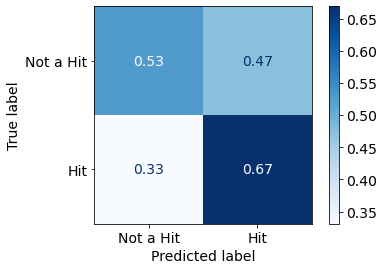

In [25]:
disp = plot_confusion_matrix(logreg, X_test_lr_sm, y_test, display_labels=['Not a Hit', 'Hit'], cmap = plt.cm.Blues, normalize='true')

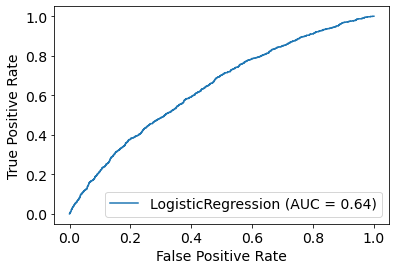

In [26]:
plot_roc_curve(logreg, X_test_lr_sm, y_test)

In [112]:
param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
clf = GridSearchCV(LogisticRegression(penalty='l2'), param_grid)
GridSearchCV(cv=None,
             estimator=LogisticRegression(C=1.0, intercept_scaling=1,   
               dual=False, fit_intercept=True, penalty='l2', tol=0.0001, 
               max_iter = 10000),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]})

GridSearchCV(estimator=LogisticRegression(max_iter=10000),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]})

In [113]:
best_clf = clf.fit(X_train_lr_sm, np.asarray(y_train_up).ravel())
best_clf.best_estimator_

LogisticRegression(C=0.001)

In [114]:
logreg2 = LogisticRegression(C=0.001)
logreg2.fit(X_train_lr_sm, np.asarray(y_train_up).ravel())

LogisticRegression(C=0.001)

In [115]:
y_pred = logreg2.predict(X_test_lr_sm)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg2.score(X_test_lr_sm, y_test)))

Accuracy of logistic regression classifier on test set: 0.56


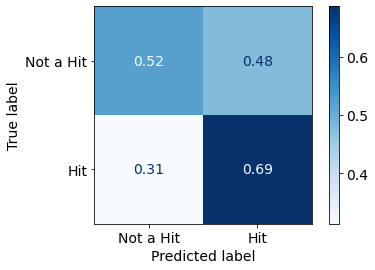

In [117]:
disp = plot_confusion_matrix(logreg2, X_test_lr_sm, y_test, display_labels=['Not a Hit', 'Hit'], cmap = plt.cm.Blues, normalize='true')

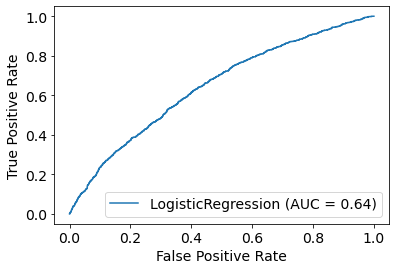

In [34]:
plot_roc_curve(logreg2, X_test_log, y_test)

## Fully Connected NN SMOTE

In [ ]:
# normalize the data before feeding into a neural network
scaler = StandardScaler()
X_train_nn = pd.DataFrame(scaler.fit_transform(X_train_up), columns=X_train_up.columns)
X_test_nn = pd.DataFrame(scaler.fit_transform(X_test), columns=X_test.columns)

In [ ]:
# create a validation set for the NN as Keras validation_split only selects the last x% of the data
X_train_nn, X_valid_nn, y_train_nn, y_valid_nn = train_test_split(X_train_nn, y_train_up, test_size=0.3, random_state=42)

In [ ]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(18,)),

    keras.layers.Dense(11, activation=tf.nn.relu, kernel_initializer='normal'),

    keras.layers.Dense(1, activation=tf.nn.sigmoid),
])

In [ ]:
# running the model
opt = keras.optimizers.Adam(lr = 0.001)
model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])

hist = model.fit(X_train_nn, y_train_nn, epochs=100, batch_size=50, validation_data=(X_valid_nn, y_valid_nn))
test_loss, test_acc = model.evaluate(X_test_nn, y_test)

Epoch 1/100
230/230 [==============================] - 0s 2ms/step - loss: 0.6689 - accuracy: 0.5968 - val_loss: 0.6532 - val_accuracy: 0.6142
Epoch 2/100
230/230 [==============================] - 0s 1ms/step - loss: 0.6450 - accuracy: 0.6248 - val_loss: 0.6467 - val_accuracy: 0.6244
Epoch 3/100
230/230 [==============================] - 0s 1ms/step - loss: 0.6394 - accuracy: 0.6292 - val_loss: 0.6427 - val_accuracy: 0.6291
Epoch 4/100
230/230 [==============================] - 0s 1ms/step - loss: 0.6346 - accuracy: 0.6305 - val_loss: 0.6392 - val_accuracy: 0.6333
Epoch 5/100
230/230 [==============================] - 0s 1ms/step - loss: 0.6304 - accuracy: 0.6415 - val_loss: 0.6350 - val_accuracy: 0.6395
Epoch 6/100
230/230 [==============================] - 0s 1ms/step - loss: 0.6270 - accuracy: 0.6442 - val_loss: 0.6328 - val_accuracy: 0.6464
Epoch 7/100
230/230 [==============================] - 0s 1ms/step - loss: 0.6238 - accuracy: 0.6470 - val_loss: 0.6292 - val_accuracy: 0.6462

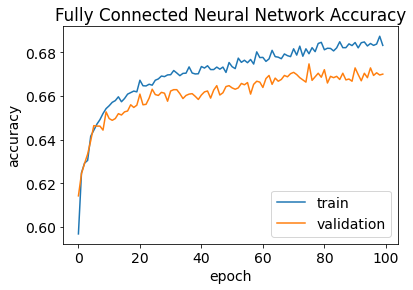

In [ ]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Fully Connected Neural Network Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

In [ ]:
print("NN SMOTE test accuracy: ", test_acc)

NN SMOTE test accuracy:  0.5865426063537598


#### MLP Classifier SMOTE
Used to compare results from the neural network

In [ ]:
model = sklearn.neural_network.MLPClassifier(hidden_layer_sizes=(15, ), activation='relu', solver='adam', 
                                             alpha=0.001, batch_size='auto', learning_rate='constant', learning_rate_init=0.001, 
                                             max_iter=1000, shuffle=True, random_state=42, tol=0.0001, validation_fraction=0.2)
# Train the model on the whole data set
model.fit(X_train_nn, np.asarray(y_train_nn).ravel())

MLPClassifier(alpha=0.001, hidden_layer_sizes=(15,), max_iter=1000,
              random_state=42, validation_fraction=0.2)

In [ ]:
predictions = model.predict(X_test_nn)
accuracy = sklearn.metrics.accuracy_score(y_test, predictions)

In [ ]:
print("MLP test accuracy: ", accuracy)

MLP test accuracy:  0.5696668109043704


## Gradient Boosting Classifier SMOTE

In [35]:
# Establishing a baseline for model performance
clf = GradientBoostingClassifier(random_state=42, n_estimators = 100, max_features = 15, learning_rate = 0.005)
clf.fit(X_train_up, np.asarray(y_train_up).ravel())
clf.predict(X_test)
clf.score(X_test, np.asarray(y_test).ravel())

0.6960190393768931

In [38]:
param_grid1 = {'n_estimators':[10,100,500,1000]}
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, min_samples_split=500,min_samples_leaf=50,max_depth=8,max_features='sqrt',subsample=0.8,random_state=42), 
param_grid = param_grid1, scoring='roc_auc',n_jobs=4,cv=3)
gsearch1.fit(X_train_up,np.asarray(y_train_up).ravel())

GridSearchCV(cv=3,
             estimator=GradientBoostingClassifier(max_depth=8,
                                                  max_features='sqrt',
                                                  min_samples_leaf=50,
                                                  min_samples_split=500,
                                                  random_state=42,
                                                  subsample=0.8),
             n_jobs=4, param_grid={'n_estimators': [10, 100, 500, 1000]},
             scoring='roc_auc')

In [39]:
gsearch1.best_params_, gsearch1.best_score_

({'n_estimators': 1000}, 0.8977511329636728)

In [40]:
param_grid2 = {'max_depth': [5,10,15,20], 'min_samples_split':[5,10,20]}
gsearch2 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=1000, max_features='sqrt', subsample=0.8, random_state=42), 
param_grid = param_grid2, scoring='roc_auc',n_jobs=4, cv=3)
gsearch2.fit(X_train_up,np.asarray(y_train_up).ravel())

GridSearchCV(cv=3,
             estimator=GradientBoostingClassifier(max_features='sqrt',
                                                  n_estimators=1000,
                                                  random_state=42,
                                                  subsample=0.8),
             n_jobs=4,
             param_grid={'max_depth': [5, 10, 15, 20],
                         'min_samples_split': [5, 10, 20]},
             scoring='roc_auc')

In [41]:
gsearch2.best_params_, gsearch2.best_score_

({'max_depth': 15, 'min_samples_split': 5}, 0.9531311772027474)

In [42]:
param_grid3 = {'min_samples_split':[5,10,50], 'min_samples_leaf':[10,25,50,100]}
gsearch3 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=1000,max_depth=15,max_features='sqrt', subsample=0.8, random_state=10), 
param_grid = param_grid3, scoring='roc_auc',n_jobs=-1,cv=3)
gsearch3.fit(X_train_up,np.asarray(y_train_up).ravel())
gsearch3.best_params_, gsearch3.best_score_

({'min_samples_leaf': 10, 'min_samples_split': 5}, 0.9433453739712346)

In [174]:
param_grid4 = {'max_features':[5,10,15,'sqrt']}
gsearch4 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=1000,max_depth=15, min_samples_split=5, min_samples_leaf=10, subsample=0.8, random_state=10),
param_grid = param_grid4, scoring='roc_auc',n_jobs=-1, cv=3)
gsearch4.fit(X_train_up,np.asarray(y_train_up).ravel())
gsearch4.best_params_, gsearch4.best_score_

({'max_features': 5}, 0.9436700336985453)

In [179]:
boosting_tuned = GradientBoostingClassifier(learning_rate=0.01, n_estimators=1000,max_depth=15,
                     min_samples_split=5,min_samples_leaf=10, subsample=0.8, random_state=10, max_features=5)
boosting_tuned.fit(X_train_up,np.asarray(y_train_up).ravel())

GradientBoostingClassifier(learning_rate=0.01, max_depth=15, max_features=5,
                           min_samples_leaf=10, min_samples_split=5,
                           n_estimators=1000, random_state=10, subsample=0.8)

In [180]:
boosting_tuned.predict(X_test)
boosting_tuned.score(X_test, np.asarray(y_test).ravel())

0.5058876811594203

In [181]:
# # Grid Search for GBC parameters: Takes (7-8 Hrs to Run locally)

# parameters = {
#     "learning_rate": [0.1],
#     "min_samples_split": [10,100,500],
#     "min_samples_leaf": [10,25,50,75],
#     "max_depth":[5,10,15,20],
#     "max_features":["log2"],
#     "criterion": ["friedman_mse"],
#     "subsample":[1.0],
#     "n_estimators":[500,750,1000]
#     }
# # pass param grid into GridSearchCV
# clf = GridSearchCV(GradientBoostingClassifier(), parameters,refit=True, n_jobs=-1)

# clf.fit(X_train_up, y_train_up)
# clf.fit(X_train_up, np.asarray(y_train_up).ravel())
# clf.predict(X_test)
# clf.score(X_test, np.asarray(y_test).ravel())

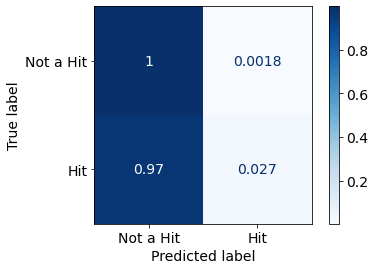

In [182]:
disp = plot_confusion_matrix(boosting_tuned, X_test, y_test, display_labels=['Not a Hit', 'Hit'], cmap = plt.cm.Blues, normalize='true')


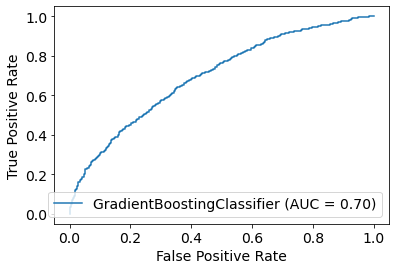

In [177]:
plot_roc_curve(boosting_tuned, X_test, y_test)

# Using Balanced non SMOTE data

In [27]:
data = pd.read_csv("data/final_subset.csv", index_col = 0)

In [28]:
data.head()

,track_popularity,playlist_genre,playlist_subgenre,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,...,tempo,duration_ms,Hit or Not,lyrical_subjectivity,lyrical_polarity,repeated_phrases,minutes,word_count,WPM_approx,artist_past_performance
1,0,3,14,0.845,0.652,-7.504,0.216,0.00432,0.007230,0.4890,...,111.904,262467,1,0.460365,0.150858,0,4.374450,420,96.012070,7
4,70,3,23,0.496,0.639,-6.157,0.055,0.28000,0.000000,0.0975,...,147.764,224720,1,0.609292,0.232474,0,3.745333,359,95.852617,0
5,52,3,14,0.764,0.594,-10.050,0.185,0.59100,0.000000,0.1450,...,87.261,286441,1,0.590514,0.200076,0,4.774017,634,132.802218,2
9,72,4,6,0.865,0.657,-6.722,0.076,0.04040,0.000000,0.1400,...,111.115,268960,1,0.409803,0.013691,3,4.482667,722,161.064842,8
11,8,3,9,0.662,0.748,-3.041,0.268,0.68800,0.000008,0.0841,...,82.331,239027,1,0.737900,0.459439,7,3.983783,554,139.063788,0


In [29]:
# Defining the relevant columns from the dataframe as some are not necessary or useful 

numerical_columns = ['danceability', 'energy', 'loudness',
            'speechiness', 'acousticness', 'instrumentalness', 
           'liveness', 'valence', 'tempo', 
           'lyrical_subjectivity', 'lyrical_polarity', 
           'repeated_phrases', 'minutes', 'word_count', 'WPM_approx', 'artist_past_performance']

categorical_columns = ['playlist_genre', 'playlist_subgenre']

target_variable = ['Hit or Not']

all_features = ['danceability', 'energy', 'loudness',
           'speechiness', 'acousticness', 'instrumentalness', 
           'liveness', 'valence', 'tempo', 
           'lyrical_subjectivity', 'lyrical_polarity', 
           'repeated_phrases', 'minutes', 'word_count', 'WPM_approx',
             'playlist_genre', 'playlist_subgenre', 'artist_past_performance']

In [30]:
# Define the X and y matrices
X = data[all_features]
y = data[target_variable]

In [31]:
# Split the data into train and test, random state for reproducability
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Logistic Regression

In [32]:
# Use recursive feature elimination to select features for logistic regression
rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=10)
rfe = rfe.fit(X_train, np.asarray(y_train).ravel())
print(rfe.support_)
print(rfe.ranking_)

[ True False  True  True  True False  True  True  True False  True False
  True False  True False False False]
[1 6 1 1 1 2 1 1 1 4 1 8 1 3 1 9 5 7]


In [33]:
# select the top features selected by RFE
f = rfe.get_support(1)
X_train_log = X_train[X_train.columns[f]]
X_test_log = X_test[X_test.columns[f]]

In [34]:
# inspecting the features selected
X_train_log.head()

,danceability,loudness,speechiness,acousticness,liveness,valence,tempo,lyrical_polarity,minutes,WPM_approx
1881,0.830,-6.279,0.4320,0.02530,0.1060,0.6070,128.160,0.000000,2.570433,50.964169
11873,0.446,-4.179,0.0295,0.02980,0.0931,0.3940,159.958,0.330382,3.950000,83.291139
4054,0.386,-8.173,0.0489,0.00287,0.2450,0.0858,110.354,-0.099383,3.463500,92.392089
9986,0.693,-7.316,0.1190,0.67900,0.2580,0.4730,81.308,0.000758,2.034450,155.324535
14265,0.764,-7.232,0.1390,0.05440,0.3100,0.6520,89.976,0.065468,3.552217,157.648041


In [37]:
logreg = LogisticRegression(max_iter = 5000)
logreg.fit(X_train_log, np.asarray(y_train).ravel())

LogisticRegression(max_iter=5000)

In [38]:
y_pred = logreg.predict(X_test_log)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test_log, y_test)))

Accuracy of logistic regression classifier on test set: 0.59


In [40]:
param_grid_log={'C': [0.001, 0.01, 0.1, 1, 10, 100]}
clf = GridSearchCV(LogisticRegression(penalty='l2'), param_grid_log)
GridSearchCV(cv=None,
             estimator=LogisticRegression(C=1.0, intercept_scaling=1,   
               dual=False, fit_intercept=True, penalty='l2', tol=0.0001, 
               max_iter = 10000),
             param_grid=param_grid_log)

GridSearchCV(estimator=LogisticRegression(max_iter=10000),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100]})

In [41]:
# scale columns for logistic regression
scaler = StandardScaler()
X_train_lr = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_lr = pd.DataFrame(scaler.fit_transform(X_test), columns=X_test.columns)

In [42]:
best_clf = clf.fit(X_train_lr, np.asarray(y_train).ravel())
best_clf.best_estimator_

LogisticRegression(C=0.001)

In [44]:
logreg_t = LogisticRegression(C=0.001)
logreg_t.fit(X_train_lr, np.asarray(y_train).ravel())

LogisticRegression(C=0.001)

In [45]:
y_pred = logreg_t.predict(X_test_lr)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg_t.score(X_test_lr, y_test)))

Accuracy of logistic regression classifier on test set: 0.61


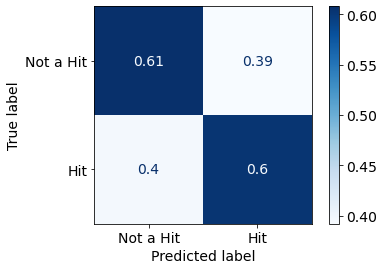

In [46]:
disp = plot_confusion_matrix(logreg_t, X_test_lr, y_test, display_labels=['Not a Hit', 'Hit'], cmap = plt.cm.Blues, normalize='true')


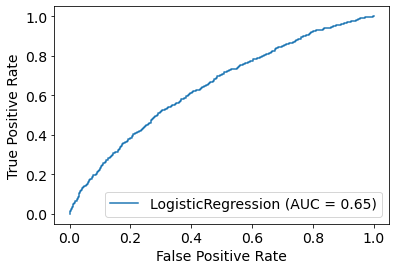

In [47]:
plot_roc_curve(logreg_t, X_test_lr, y_test)

## Fully Connected Neural Network

In [135]:
# scale the data before passing into neural network
scaler = StandardScaler()
X_train_nn = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_nn = pd.DataFrame(scaler.fit_transform(X_test), columns=X_test.columns)

In [136]:
# create a validation set for the NN as Keras validation_split only selects the last x% of the data
X_train_nn, X_valid_nn, y_train_nn, y_valid_nn = train_test_split(X_train_nn, y_train, test_size=0.3, random_state=42)

In [137]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(18,)),

    keras.layers.Dense(12, activation=tf.nn.relu, kernel_initializer='glorot_normal'),

    keras.layers.Dense(1, activation=tf.nn.sigmoid),
])

In [141]:
# Load NN instead of retraining, uncomment line below
# model = tf.keras.models.load_model("data/NN.h5")

In [138]:
opt = keras.optimizers.Adam(lr = 0.0001)
model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])

hist = model.fit(X_train_nn, y_train_nn, epochs=200, batch_size=50, validation_data = (X_valid_nn, y_valid_nn))
test_loss, test_acc = model.evaluate(X_test, y_test)

Epoch 1/200
73/73 [==============================] - 0s 3ms/step - loss: 0.8025 - accuracy: 0.5320 - val_loss: 0.7884 - val_accuracy: 0.5217
Epoch 2/200
73/73 [==============================] - 0s 980us/step - loss: 0.7896 - accuracy: 0.5334 - val_loss: 0.7771 - val_accuracy: 0.5243
Epoch 3/200
73/73 [==============================] - 0s 1ms/step - loss: 0.7783 - accuracy: 0.5379 - val_loss: 0.7675 - val_accuracy: 0.5301
Epoch 4/200
73/73 [==============================] - 0s 1ms/step - loss: 0.7685 - accuracy: 0.5404 - val_loss: 0.7589 - val_accuracy: 0.5340
Epoch 5/200
73/73 [==============================] - 0s 1ms/step - loss: 0.7595 - accuracy: 0.5395 - val_loss: 0.7510 - val_accuracy: 0.5340
Epoch 6/200
73/73 [==============================] - 0s 1ms/step - loss: 0.7513 - accuracy: 0.5412 - val_loss: 0.7440 - val_accuracy: 0.5314
Epoch 7/200
73/73 [==============================] - 0s 1ms/step - loss: 0.7439 - accuracy: 0.5429 - val_loss: 0.7374 - val_accuracy: 0.5359
Epoch 8/200

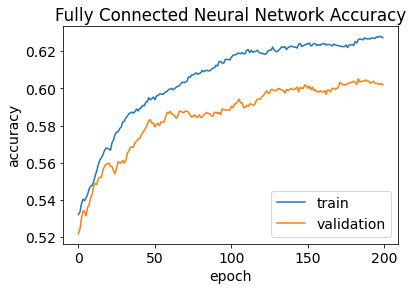

In [139]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Fully Connected Neural Network Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

In [178]:
# model.save("data/NN.h5")

In [142]:
y_pred = model.predict(X_test_nn)

#### Calculating the confusion matrix for Neural Network

In [143]:
y_p_ = np.where(np.asarray(y_pred)>= 0.5, 1, 0).flatten()

In [144]:
counts = Counter(zip(y_p_, y_test.to_numpy().flatten().tolist()))
tp = counts[1,1]
fp = counts[1,0]
tn = counts[0,0]
fn = counts[0,1]

In [150]:
display(print(tp / (tp+fn)), print(tn / (tn+fp)), print(1 - (tp / (tp+fn))), print(1 - (tn / (tn+fp))))

0.5951742627345844
0.6051423324150597
0.4048257372654156
0.39485766758494034


None

None

None

None

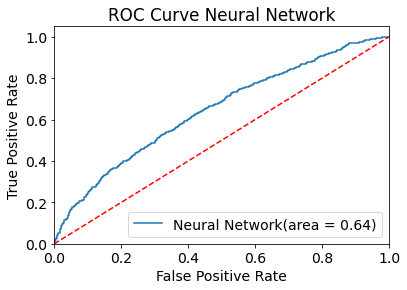

In [152]:
# ROC curve for Neural Network
nn_roc_auc = roc_auc_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.figure()
plt.plot(fpr, tpr, label='Neural Network(area = %0.2f)' % nn_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Neural Network')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

## Gradient Boosting Classifier

In [154]:
param_grid1_r = {'n_estimators':[10,100,500,1000]}
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, min_samples_split=10,min_samples_leaf=5,max_depth=8,max_features='sqrt',subsample=0.8,random_state=42), 
param_grid = param_grid1_r, scoring='roc_auc',n_jobs=4,cv=3)
gsearch1.fit(X_train,np.asarray(y_train).ravel())

GridSearchCV(cv=3,
             estimator=GradientBoostingClassifier(max_depth=8,
                                                  max_features='sqrt',
                                                  min_samples_leaf=5,
                                                  min_samples_split=10,
                                                  random_state=42,
                                                  subsample=0.8),
             n_jobs=4, param_grid={'n_estimators': [10, 100, 500, 1000]},
             scoring='roc_auc')

In [155]:
gsearch1.best_params_, gsearch1.best_score_

({'n_estimators': 1000}, 0.7035097765768815)

In [156]:
param_grid2_r = {'max_depth': [5,10,15,20], 'min_samples_split':[5,10,20]}
gsearch2 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=1000, max_features='sqrt', subsample=0.8, random_state=42), 
param_grid = param_grid2_r, scoring='roc_auc',n_jobs=4, cv=3)
gsearch2.fit(X_train,np.asarray(y_train).ravel())

GridSearchCV(cv=3,
             estimator=GradientBoostingClassifier(max_features='sqrt',
                                                  n_estimators=1000,
                                                  random_state=42,
                                                  subsample=0.8),
             n_jobs=4,
             param_grid={'max_depth': [5, 10, 15, 20],
                         'min_samples_split': [5, 10, 20]},
             scoring='roc_auc')

In [157]:
gsearch2.best_params_, gsearch2.best_score_

({'max_depth': 20, 'min_samples_split': 5}, 0.7186379311271992)

In [158]:
param_grid3_r = {'min_samples_split':[5,10,25], 'min_samples_leaf':[5,10,25,50]}
gsearch3 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=1000,max_depth=20,max_features='sqrt', subsample=0.8, random_state=42), 
param_grid = param_grid3_r, scoring='roc_auc',n_jobs=-1,cv=3)
gsearch3.fit(X_train,np.asarray(y_train).ravel())
gsearch3.best_params_, gsearch3.best_score_

({'min_samples_leaf': 5, 'min_samples_split': 5}, 0.7160202872276703)

In [159]:
param_grid4_r = {'max_features':[5,10,15,'sqrt']}
gsearch4 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=1000,max_depth=15, min_samples_split=5, min_samples_leaf=5, subsample=0.8, random_state=10),
param_grid = param_grid4_r, scoring='roc_auc',n_jobs=-1, cv=3)
gsearch4.fit(X_train,np.asarray(y_train).ravel())
gsearch4.best_params_, gsearch4.best_score_

({'max_features': 5}, 0.7153894388245243)

In [160]:
gs_tuned = GradientBoostingClassifier(learning_rate=0.01, n_estimators=1000,max_depth=15,
                     min_samples_split=5,min_samples_leaf=5, subsample=0.8, random_state=10, max_features=5)
gs_tuned.fit(X_train,np.asarray(y_train).ravel())

GradientBoostingClassifier(learning_rate=0.01, max_depth=15, max_features=5,
                           min_samples_leaf=5, min_samples_split=5,
                           n_estimators=1000, random_state=10, subsample=0.8)

In [161]:
# # Grid Search for GB Classifier
# parameters = {
#     "learning_rate": [0.1],
#     "min_samples_split": [5,10,20],
#     "min_samples_leaf": [2,5,10],
#     "max_depth":[5,10,15],
#     "max_features":["log2", 'sqrt'],
#     "criterion": ["friedman_mse"],
#     "subsample":[0.8,1.0],
#     "n_estimators":[700,900,1000]
#     }
# # pass param grid into GridSearchCV
# clf = GridSearchCV(GradientBoostingClassifier(), parameters,refit=False, n_jobs=-1)

# clf.fit(X_train, y_train)
# clf.best_params_

In [162]:
# clfb = GradientBoostingClassifier(criterion= 'friedman_mse',
#                                      learning_rate= 0.01,
#                                      max_depth= 15, 
#                                      max_features= 'log2',
#                                      min_samples_leaf= 2,
#                                      min_samples_split= 5, 
#                                      n_estimators= 700,
#                                      subsample= 1,
#                                     random_state = 42)

In [163]:
# clfb.fit(X_train, np.asarray(y_train).ravel())

In [164]:
gs_tuned.predict(X_test)
gs_tuned.score(X_test, np.asarray(y_test).ravel())

0.6766304347826086

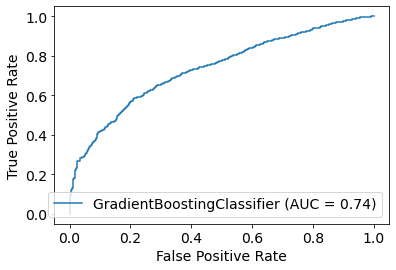

In [165]:
plot_roc_curve(gs_tuned, X_test, y_test)

In [166]:
X_train.head()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,lyrical_subjectivity,lyrical_polarity,repeated_phrases,minutes,word_count,WPM_approx,playlist_genre,playlist_subgenre,artist_past_performance
1881,0.830,0.794,-6.279,0.4320,0.02530,0.024800,0.1060,0.6070,128.160,0.000000,0.000000,3,2.570433,131,50.964169,0,1,0
11873,0.446,0.701,-4.179,0.0295,0.02980,0.000009,0.0931,0.3940,159.958,0.741493,0.330382,0,3.950000,329,83.291139,1,11,0
4054,0.386,0.708,-8.173,0.0489,0.00287,0.000023,0.2450,0.0858,110.354,0.516049,-0.099383,0,3.463500,320,92.392089,2,10,0
9986,0.693,0.497,-7.316,0.1190,0.67900,0.000000,0.2580,0.4730,81.308,0.249242,0.000758,3,2.034450,316,155.324535,5,0,10
14265,0.764,0.732,-7.232,0.1390,0.05440,0.000000,0.3100,0.6520,89.976,0.564947,0.065468,10,3.552217,560,157.648041,3,14,2


In [167]:
gs_tuned.feature_importances_

array([0.0607928 , 0.05659393, 0.05780576, 0.08015387, 0.06459858,
       0.04511852, 0.06256507, 0.06598296, 0.06470871, 0.06199404,
       0.06972529, 0.02393028, 0.08169931, 0.05817079, 0.05813303,
       0.02150991, 0.03678401, 0.02973314])

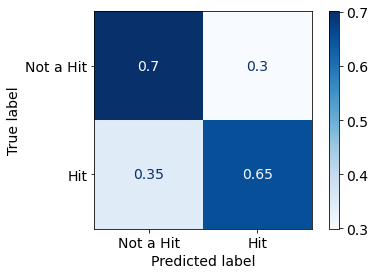

In [168]:
disp = plot_confusion_matrix(gs_tuned, X_test, y_test, display_labels=['Not a Hit', 'Hit'], cmap = plt.cm.Blues, normalize='true')


## XGBoost

In [169]:
xgb = XGBClassifier(max_depth = 10, min_child_weight = 4, subsample = 0.8, colsample_bytree = 1
                        ,n_estimators = 1000, booster = 'gbtree', objective= 'binary:logistic'
                      ,random_state = 42, learning_rate = 0.01)
xgb.fit(X_train, np.asarray(y_train).ravel())

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=10,
              min_child_weight=4, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=0, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [170]:
y_pred = xgb.predict(X_test)
predictions = [round(value) for value in y_pred]

In [171]:
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 66.53%


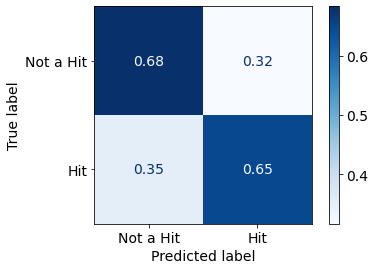

In [172]:
disp = plot_confusion_matrix(xgb, X_test, y_test, display_labels=['Not a Hit', 'Hit'], cmap = plt.cm.Blues, normalize='true')


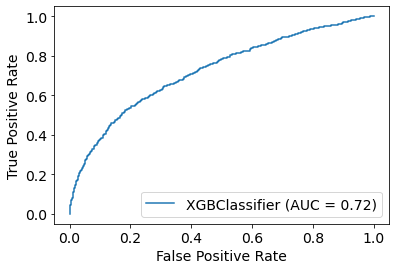

In [173]:
plot_roc_curve(xgb, X_test, y_test)